In [66]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [67]:
# Define the transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [70]:
import torch
import torch.nn as nn

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.SiLU()  # Swish activation function

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation(self.conv3(x))
        x = self.maxpool(x)
        x = self.activation(self.conv4(x))
        x = self.global_maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
model = MNISTModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / len(train_dataset)

    # Evaluation on the test dataset
    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * test_correct / len(test_dataset)

    # Print the training and validation metrics for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/5], Train Loss: 0.2823, Train Accuracy: 90.81%, Test Loss: 0.0625, Test Accuracy: 98.03%
Epoch [2/5], Train Loss: 0.0596, Train Accuracy: 98.12%, Test Loss: 0.0530, Test Accuracy: 98.31%
Epoch [3/5], Train Loss: 0.0401, Train Accuracy: 98.75%, Test Loss: 0.0309, Test Accuracy: 98.98%
Epoch [4/5], Train Loss: 0.0328, Train Accuracy: 98.96%, Test Loss: 0.0322, Test Accuracy: 98.90%
Epoch [5/5], Train Loss: 0.0247, Train Accuracy: 99.24%, Test Loss: 0.0341, Test Accuracy: 98.98%


In [72]:
import numpy as np

samples = []
labels = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        # Convert images and targets to numpy arrays
        samples.append(images.numpy())
        labels.append(targets.numpy())

        # Break the loop after processing one batch
        break

# Convert the lists to numpy arrays
samples = np.concatenate(samples, axis=0)
labels = np.concatenate(labels, axis=0)

# Remove the extra dimension in samples
samples = np.squeeze(samples, axis=1)

# Convert the numpy arrays to tensors and reshape
samples = torch.from_numpy(samples).unsqueeze(1)

# Move the samples tensor to the appropriate device (GPU/CPU)
samples = samples.to(device)

# Make predictions using the model
predictions = model(samples)

# Convert the predictions tensor to a numpy array
predictions = predictions.detach().numpy()

# Compute the predicted labels by taking the argmax
predicted_labels = np.argmax(predictions, axis=1)

# Assert the shapes of samples and labels
assert samples.shape[0] == labels.shape[0]


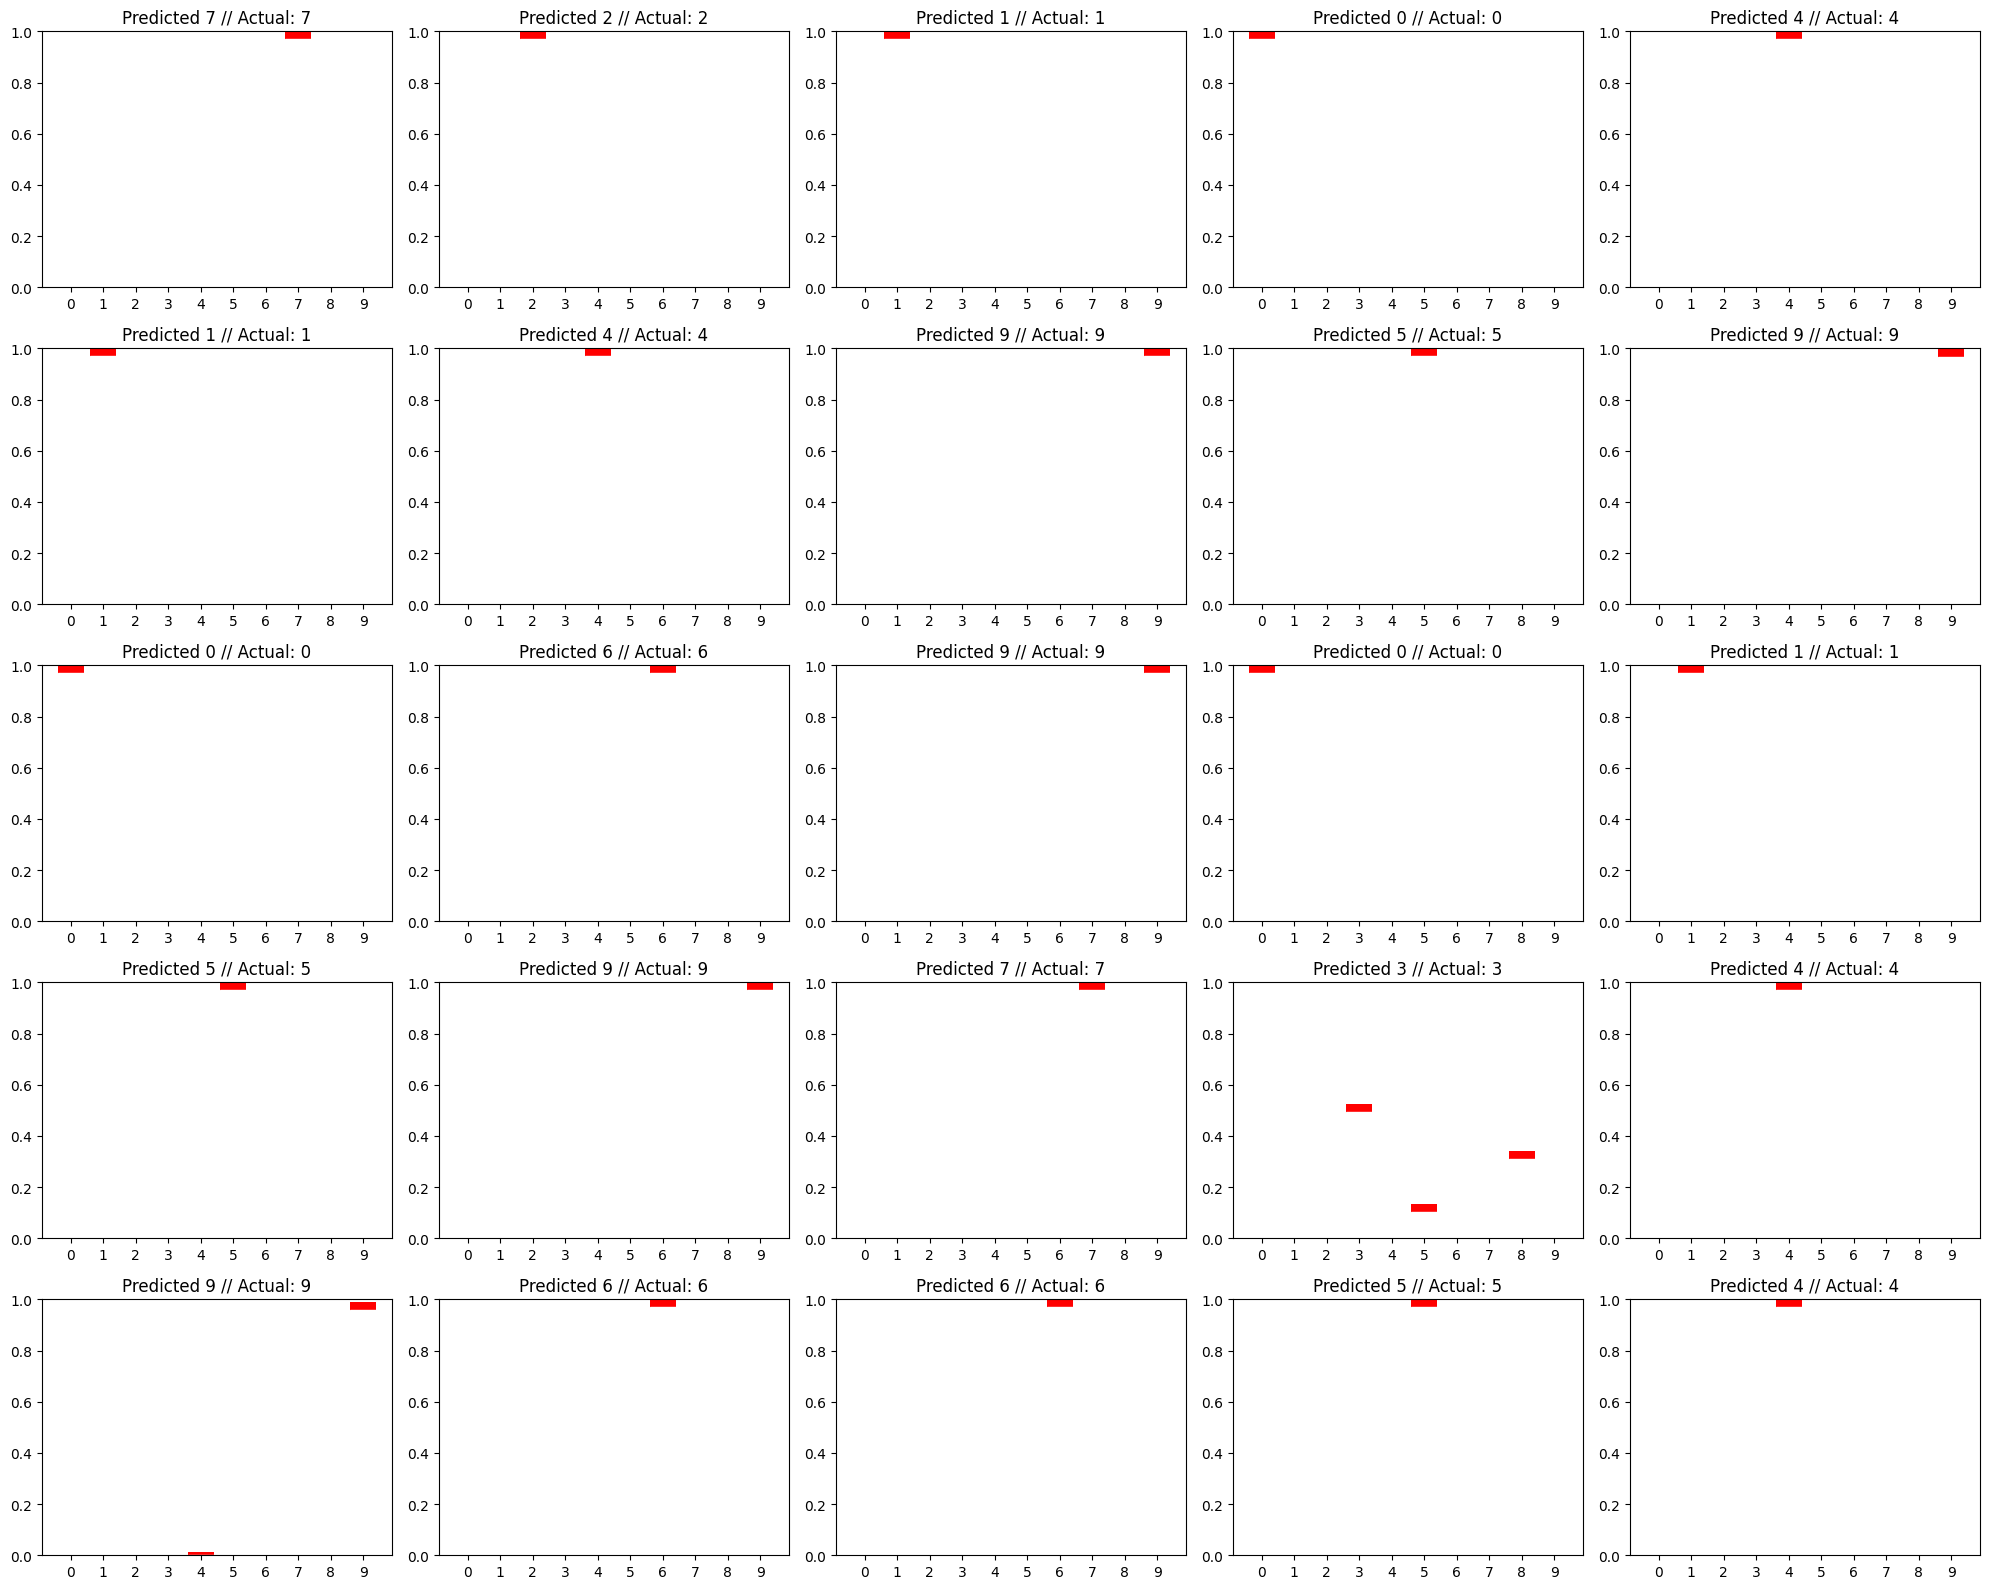

In [73]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_predictions(predictions, labels):
    plt.figure(figsize=(20, 16))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        probs = F.softmax(torch.tensor(predictions[i]), dim=0).numpy()
        plt.bar(range(10), probs, color='red')
        plt.bar(range(10), probs - 0.03, color='white', linewidth=1, edgecolor='white')
        plt.title('Predicted %d // Actual: %d' % (np.argmax(predictions[i]), labels[i]))
        plt.ylim([0, 1])
        plt.xticks(range(10))

    plt.tight_layout()
    plt.show()

# Plot the predictions and labels
plot_predictions(predictions, labels)


#### For the first plot, the correct label was 7 and the model output such a high softmax value for that sample which is almost equals to 1 because the accuracy of our model is 99.1% which is almost equals to 100%  Although the softmax values are high, this does not tell how sure the model is , the magnitude of the probabilities alone does not convey the model's certainty.

{0: 12.525879, 1: 4.351056, 2: 10.663928, 3: 6.2590256, 4: 6.4874554, 5: 7.9441795, 6: 10.895645, 7: 7.171645, 8: 27.160648, 9: 6.5405436}


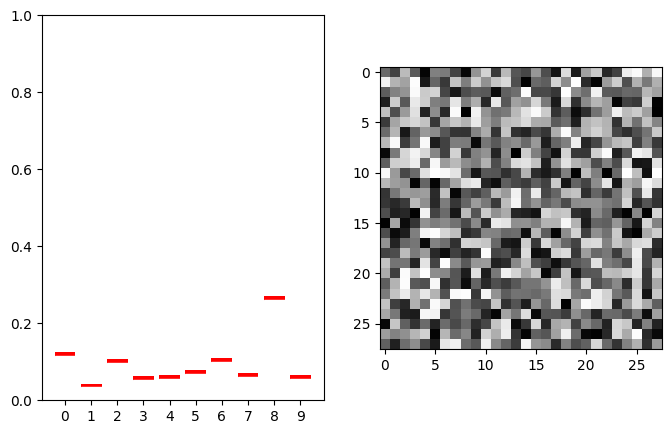

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def random_noise_prediction(model=None, random_vector=None, ensemble=False):
    random_vector = random_vector.astype(np.float32)

    if ensemble:
        predictions = []
        for i in range(ensemble):
            predictions.append(model(torch.from_numpy(random_vector.transpose((2, 0, 1))).unsqueeze(0)).detach().numpy().squeeze())
        predict_noise = np.mean(predictions, axis=0)
    else:
        with torch.no_grad():
            predict_noise = model(torch.from_numpy(random_vector.transpose((2, 0, 1))).unsqueeze(0)).squeeze().numpy()

    predict_noise = F.softmax(torch.tensor(predict_noise), dim=0).numpy()  # Apply softmax to normalize the values

    print({key: value for key, value in enumerate(predict_noise * 100)})

    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(10), predict_noise, color='red')
    plt.bar(range(10), predict_noise - 0.01, color='white', linewidth=1, edgecolor='white')
    plt.grid(False)
    plt.xticks(range(10))
    plt.ylim([0, 1])
    plt.subplot(1, 2, 2)
    plt.imshow(random_vector.squeeze(), cmap=plt.cm.gray)
    plt.show()


random_vector = np.random.uniform(low=0, high=1, size=(28, 28, 1)).astype(np.float32)

random_noise_prediction(model, random_vector)


#### According to the softmax output, there is 27% probability that this given vector belongs to class 8 after adding the noise.

# ----------------------------------------------------------------

### Dropout is a regularization technique employed in deep learning in order to prevent overfitting. It works by randomly dropping units (neurons) out of the network during the training process, with the hope that this will prevent any one neuron from becoming too influential

In [ ]:
class MNISTModel2(nn.Module):
    def __init__(self):
        super(MNISTModel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding = 1)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding = 1)
        self.dropout = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        self.dropout = nn.Dropout(0.5)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.SiLU()  

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation(self.conv3(x))
        x = self.maxpool(x)
        x = self.activation(self.conv4(x))
        x = self.global_maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x
        

model2 = MNISTModel2()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / len(train_dataset)

    # Evaluation on the test dataset
    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * test_correct / len(test_dataset)

    # Print the training and validation metrics for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
